In [ ]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#load a dataset
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

#load all train images to tensor
train_image_list = get_image_files(path/'training')
train_digits = [tensor(Image.open(o)) for o in train_image_list]
train_x = (torch.stack(train_digits).float() / 255).view(-1, 28*28)

#load labels
train_y = tensor([int(o.parent.name) for o in train_image_list]).view(-1, 1)

#load a valid dataset
valid_image_list = get_image_files(path/'testing')
valid_digits = [tensor(Image.open(o)) for o in valid_image_list]
valid_x = (torch.stack(valid_digits).float() / 255).view(-1, 28*28)
valid_y_list = [int(o.parent.name) for o in valid_image_list]
valid_y = tensor(valid_y_list).view(-1, 1)

#convert to Dataloader
dset = list(zip(train_x, train_y))
dl = DataLoader(dset, batch_size=256)
valid_dset = list(zip(valid_x, valid_y))


In [ ]:
#model
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

In [ ]:
#loss function
def mnist_loss(pred, target):
  loss = nn.CrossEntropyLoss()
  return loss(pred, target.squeeze())

#gradient calculation
def calc_grad(x, y, model):
  pred = model(x)
  loss = mnist_loss(pred, y)
  loss.backward()

In [ ]:
#SGD optimizer
class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr
    def step(self):
        for p in self.params: p.data -= p.grad*lr
    def zero_grad(self):
        for p in self.params: p.grad = None

In [ ]:
class Trainer:
  def __init__(self, model, optimiser, pred, actual):
        self.model = model
        self.opt = optimiser
        self.pred = pred
        self.actual = actual

  #backpropagation
  def train_epoch(self):
    for x, y in dl:
        calc_grad(x, y, self.model)
        self.opt.step()
        self.opt.zero_grad()

  #accuracy
  def epoche_accuracy(self):
    pred = self.model(self.pred)
    digit_pred = pred.max(dim=1)[1]
    return (digit_pred==self.actual.squeeze()).float().mean()



In [ ]:
list_of_accuracy=[]
lr = 0.0005
opt = BasicOptim(simple_net.parameters(), lr)
trainer = Trainer(simple_net, opt, valid_x, valid_y)

def train_model(epoches):
  for i in range(epoches):
      trainer.train_epoch()
      list_of_accuracy.append(trainer.epoche_accuracy())

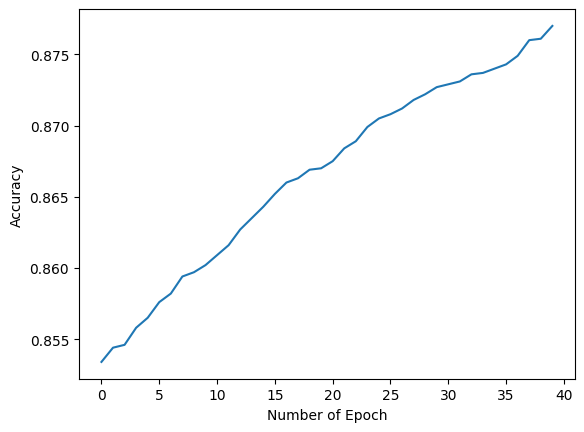

In [ ]:
#accuracy plot
train_model(40)
x = [i for i in range(40)]
fig, ax = plt.subplots()
ax.set_xlabel('Number of Epoch')
ax.set_ylabel('Accuracy')
ax.plot(x,list_of_accuracy)